Time series prediction task

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from statsmodels.datasets import elnino
import time
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath('..'))
from kans import BSplineKAN, FourierKAN, GaussianKAN, JacobiKAN, RationalKAN, TaylorKAN, WaveletKAN, BernsteinKAN, MLP

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if os.path.exists('model') is False:
	os.makedirs('model')

cpu


In [2]:
def create_series_dataset(series, history_size):
    X, Y = [], []
    for i in range(len(series) - history_size):
        X.append(series[i:i+history_size].flatten())
        Y.append(series[i+history_size])
    return torch.stack(X), torch.stack(Y)

def test(model, test_input, test_data, criterion):
	model.eval()
	predict_data = torch.empty(test_data.size())
	with torch.no_grad():
		for i in range(len(test_data)):
			output = model(test_input)
			predict_data[i] = output
			test_input = torch.cat((test_input[:,test_data.size(1):], output), dim=1)
		loss = criterion(predict_data, test_data)
	return loss.item(), predict_data

def plot_fitting_and_predict(model, model_name, series, X_train, test_input, test_data, criterion, series_mean, series_std):
	train_predict = model(X_train).detach()
	test_loss, test_predict = test(model, test_input, test_data, criterion)
	print(f'Test Loss of {model_name}: {test_loss:.4f}')
	train_predict = train_predict * series_std + series_mean
	test_predict = test_predict * series_std + series_mean
	series = series * series_std + series_mean
	channel_size = series.size(1)
	history_size = X_train.size(1) // channel_size
	for i in range(channel_size):
		plt.figure(figsize=(8,6))
		plt.plot(series[:,i], label='True Data', color='b', linestyle='dashed', alpha=0.5)
		plt.plot(range(history_size, len(train_predict)+history_size), train_predict[:,i], label='Fitting Data', color='r')
		plt.plot(range(len(train_predict)+history_size, len(series)), test_predict[:,i], label='Predict Data', color='g')
		plt.title(f'{model_name} Fitting and Predict (channel{i+1})')
		plt.xlabel('Time Index')
		plt.ylabel('Value')
		plt.grid(True)
		plt.legend()
		plt.show()

def train(model, series, model_name='', test_ratio=0.2, history_size=2, batch_size = 8, num_epochs=50, save=False, criterion=nn.MSELoss()):
	print('-'*50)
	
	# Normalize data
	series_mean = series.mean(dim=0)
	series_std = series.std(dim=0)
	series = (series - series_mean) / series_std
	
	# Split data
	test_size = int(len(series) * test_ratio)
	train_data = series[:-test_size]
	test_data = series[-test_size:]
	train_X, train_Y = create_series_dataset(train_data, history_size)
	test_input = train_data[-history_size:].flatten().unsqueeze(0)
	
	# Create data loader
	train_dataset = TensorDataset(train_X, train_Y)
	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	
	# Training
	print(f'Training {model_name} model...')
	optimizer = optim.Adam(model.parameters(), lr=0.01)
	epoch_losses = []
	test_losses = []
	bar = tqdm(total=num_epochs)
	start_t = time.time()
	for epoch in range(num_epochs):
		running_loss = 0.0
		model.train()
		for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
			outputs = model(inputs)
			loss = criterion(outputs, labels)
            
            # Backward and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
            
            # Record loss
			running_loss += loss.item()
        
        # Print information every certain steps
		epoch_loss = running_loss / len(train_loader)
		epoch_losses.append(epoch_loss)
		test_loss, _ = test(model, test_input, test_data, criterion)
		test_losses.append(test_loss)
		bar.set_description(f'{model_name} Epoch {epoch+1}')
		bar.set_postfix(loss=f'{epoch_loss:.4f}', test_loss=f'{test_loss:.4f}')
		bar.update(1)
	bar.close()
	end_t = time.time()
	epoch_time = (end_t - start_t) / num_epochs
	print(f'Average Epoch Training Time :{epoch_time}s')
	plot_fitting_and_predict(model, model_name, series, train_X, test_input, test_data, criterion, series_mean, series_std)
	if save:
		torch.save(model.state_dict(), f'model/{model_name}.pth')
		print(f'Model saved as model/{model_name}.pth')
	return epoch_losses, test_losses, epoch_time

In [3]:
elnino.load_pandas().data

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2006.0,24.76,26.52,26.22,24.29,23.84,22.82,22.20,21.89,21.93,22.46,22.61,24.15
57,2007.0,25.82,26.81,26.41,24.96,23.05,21.61,21.05,19.95,19.85,19.31,19.82,21.15
58,2008.0,24.24,26.39,26.91,25.68,24.43,23.19,23.02,22.14,21.60,21.39,21.54,22.73
59,2009.0,24.39,25.53,25.48,25.84,24.95,24.09,23.09,22.03,21.48,21.64,21.99,23.21


In [4]:
# Generate series
series = torch.tensor(elnino.load_pandas().data.values[:,1:], dtype=torch.float64, device=device).flatten().unsqueeze(1)
series.shape

torch.Size([732, 1])

In [5]:
# Training settings
test_ratio = 0.2
history_size = 4 # history time steps
batch_size = 8
num_epochs = 20
save = True
criterion = nn.MSELoss()

# Setting of the model: The number of learnable parameters per layer is: input_size * output_size * (p + 1)
layer_sizes = [4, 8, 1]  # Specify the number of nodes per layer

# b_kan: p = b_grid_count
b_order = 3  # Order of B-spline
b_grid_range = [-1,1]  # Grid range of B-spline
b_grid_count = 6  # Grid count of B-spline

# f_kan: p = frequency_count * 2 + 1
frequency_count = 3  # Frequency count of Fourier series

# g_kan: p = g_grid_count
g_grid_range = [-1,1]  # Grid range of Gaussian radial basis function
g_grid_count = 6 # Grid count of Gaussian radial basis function

# j_kan: p = j_order + 1
j_order = 5  # Order of Jacobi polynomial
alpha = 0.5  # Alpha of Jacobi polynomial
beta = 0.5  # Beta of Jacobi polynomial

# r_kan: p = mole_order + deno_order + 1
mole_order = 3  # Order of numerator
deno_order = 2  # Order of denominator

# t_kan: p = t_order + 1
t_order = 5  # Order of Taylor polynomial

# w_kan: p = wave_num * 3
wave_num = 2  # Number of wavelets
wave_type = 'morlet'  # Type of wavelet

# be_kan: p = be_order + 1
be_order = 5  # Order of Bernstein polynomial
inter_range = [0, 1]  # Interpolation range

# mlp: p = p_num
p_num = 6  # Number of learnable parameters per input-output pair

--------------------------------------------------
Training MLP_elnino model...


MLP_elnino Epoch 20: 100%|██████████████████████████████| 20/20 [00:17<00:00,  1.11it/s, loss=0.0660, test_loss=1.2545]


Average Epoch Training Time :0.8974409699440002s
Test Loss of MLP_elnino: 1.2545


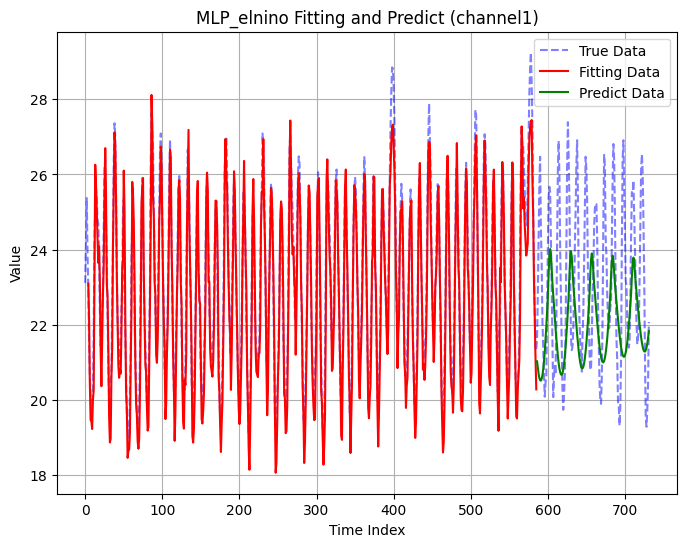

Model saved as model/MLP_elnino.pth
--------------------------------------------------
Training BSplineKAN_elnino model...


BSplineKAN_elnino Epoch 20: 100%|███████████████████████| 20/20 [01:48<00:00,  5.40s/it, loss=0.0606, test_loss=0.3513]


Average Epoch Training Time :5.404206800460815s
Test Loss of BSplineKAN_elnino: 0.3513


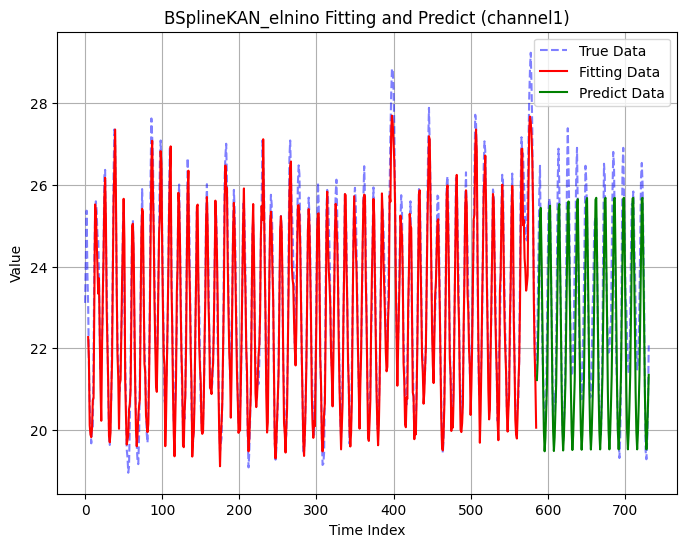

Model saved as model/BSplineKAN_elnino.pth
--------------------------------------------------
Training FourierKAN_elnino model...


FourierKAN_elnino Epoch 20: 100%|███████████████████████| 20/20 [01:13<00:00,  3.69s/it, loss=0.0586, test_loss=2.0095]


Average Epoch Training Time :3.6902583360672s
Test Loss of FourierKAN_elnino: 2.0095


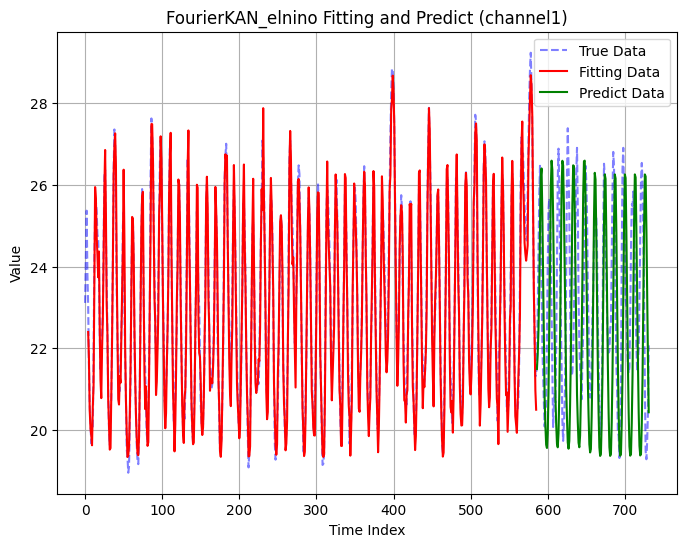

Model saved as model/FourierKAN_elnino.pth
--------------------------------------------------
Training GaussianKAN_elnino model...


GaussianKAN_elnino Epoch 20: 100%|██████████████████████| 20/20 [01:07<00:00,  3.37s/it, loss=0.0564, test_loss=1.4762]


Average Epoch Training Time :3.368541693687439s
Test Loss of GaussianKAN_elnino: 1.4762


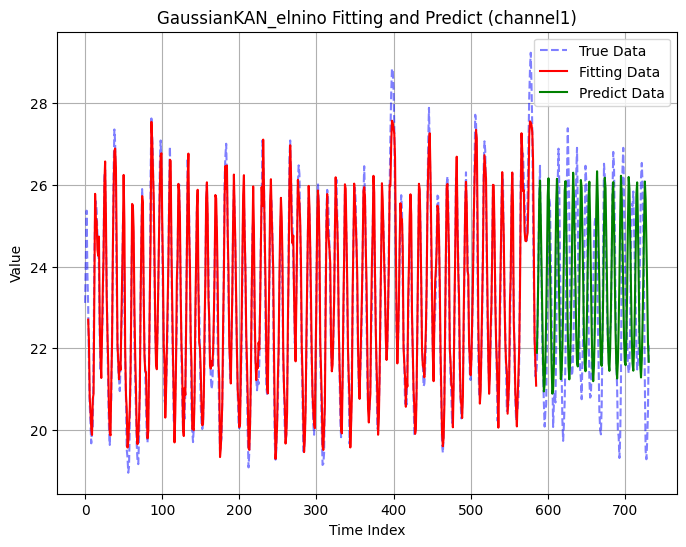

Model saved as model/GaussianKAN_elnino.pth
--------------------------------------------------
Training JacobiKAN_elnino model...


JacobiKAN_elnino Epoch 20: 100%|████████████████████████| 20/20 [01:12<00:00,  3.63s/it, loss=0.0582, test_loss=2.2071]


Average Epoch Training Time :3.633355236053467s
Test Loss of JacobiKAN_elnino: 2.2071


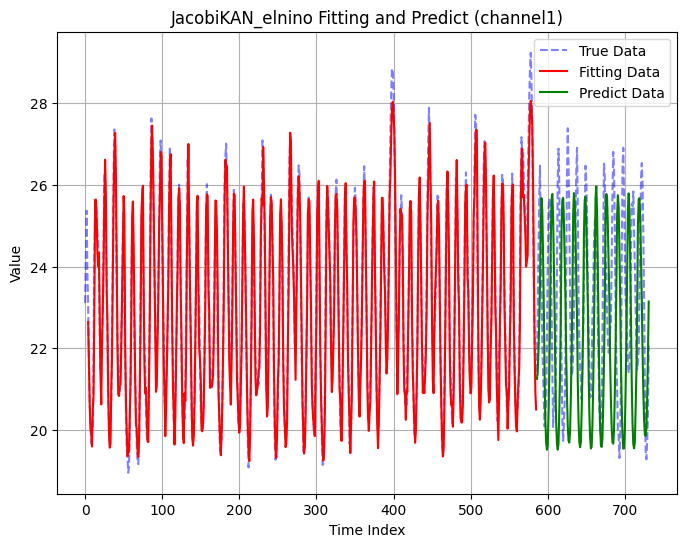

Model saved as model/JacobiKAN_elnino.pth
--------------------------------------------------
Training RationalKAN_elnino model...


RationalKAN_elnino Epoch 20: 100%|██████████████████████| 20/20 [01:12<00:00,  3.64s/it, loss=0.0702, test_loss=2.1159]


Average Epoch Training Time :3.6365817189216614s
Test Loss of RationalKAN_elnino: 2.1159


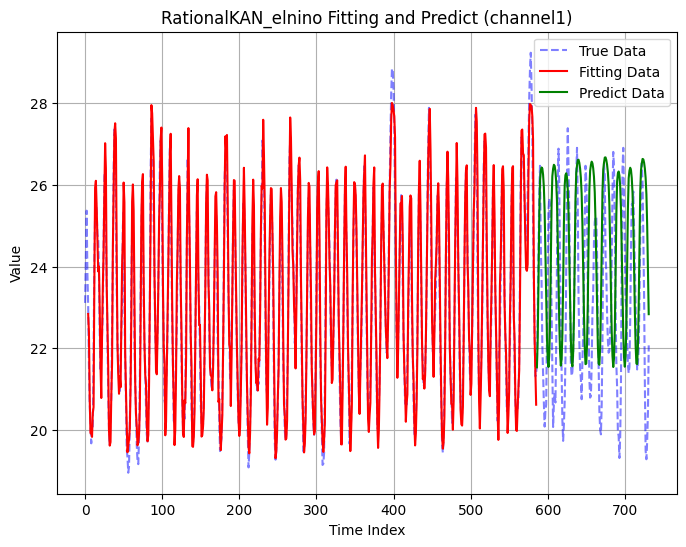

Model saved as model/RationalKAN_elnino.pth
--------------------------------------------------
Training TaylorKAN_elnino model...


TaylorKAN_elnino Epoch 20: 100%|████████████████████████| 20/20 [00:52<00:00,  2.63s/it, loss=0.0598, test_loss=1.8035]


Average Epoch Training Time :2.6295268416404722s
Test Loss of TaylorKAN_elnino: 1.8035


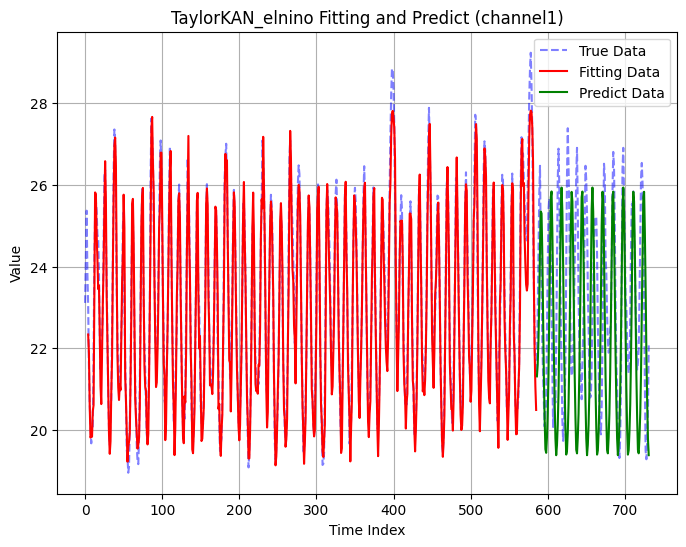

Model saved as model/TaylorKAN_elnino.pth
--------------------------------------------------
Training WaveletKAN_elnino model...


WaveletKAN_elnino Epoch 20: 100%|███████████████████████| 20/20 [01:36<00:00,  4.84s/it, loss=0.0770, test_loss=1.0324]


Average Epoch Training Time :4.844272351264953s
Test Loss of WaveletKAN_elnino: 1.0324


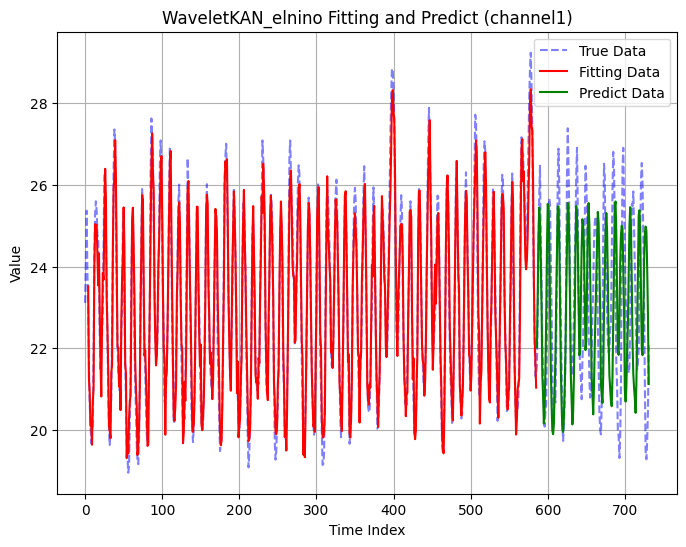

Model saved as model/WaveletKAN_elnino.pth
--------------------------------------------------
Training BernsteinKAN_elnino model...


BernsteinKAN_elnino Epoch 20: 100%|█████████████████████| 20/20 [01:16<00:00,  3.83s/it, loss=0.0661, test_loss=1.4241]


Average Epoch Training Time :3.828142488002777s
Test Loss of BernsteinKAN_elnino: 1.4241


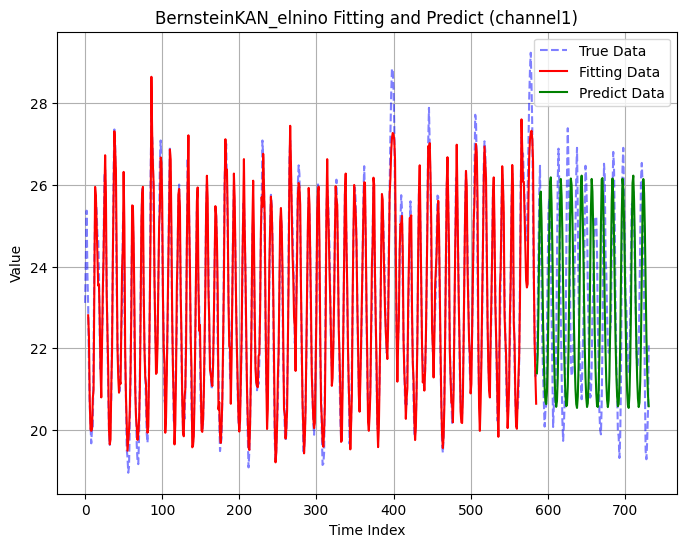

Model saved as model/BernsteinKAN_elnino.pth


In [6]:
# Training
# mlp
model = MLP(layer_sizes, p_num).to(device)
mlp_epoch_losses, mlp_test_losses, mlp_epoch_time = train(model, series, 'MLP_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# b_kan
model = BSplineKAN(layer_sizes, b_order, b_grid_range, b_grid_count).to(device)
b_epoch_losses, b_test_losses, b_epoch_time = train(model, series, 'BSplineKAN_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# f_kan
model = FourierKAN(layer_sizes, frequency_count).to(device)
f_epoch_losses, f_test_losses, f_epoch_time = train(model, series, 'FourierKAN_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# g_kan
model = GaussianKAN(layer_sizes, g_grid_range, g_grid_count).to(device)
g_epoch_losses, g_test_losses, g_epoch_time = train(model, series, 'GaussianKAN_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# j_kan
model = JacobiKAN(layer_sizes, j_order, alpha, beta).to(device)
j_epoch_losses, j_test_losses, j_epoch_time = train(model, series, 'JacobiKAN_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# r_kan
model = RationalKAN(layer_sizes, mole_order, deno_order).to(device)
r_epoch_losses, r_test_losses, r_epoch_time = train(model, series, 'RationalKAN_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# t_kan
model = TaylorKAN(layer_sizes, t_order).to(device)
t_epoch_losses, t_test_losses, t_epoch_time = train(model, series, 'TaylorKAN_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# w_kan
model = WaveletKAN(layer_sizes, wave_num, wave_type).to(device)
w_epoch_losses, w_test_losses, w_epoch_time = train(model, series, 'WaveletKAN_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

# be_kan
model = BernsteinKAN(layer_sizes, be_order, inter_range).to(device)
be_epoch_losses, be_test_losses, be_epoch_time = train(model, series, 'BernsteinKAN_elnino', test_ratio, history_size, batch_size, num_epochs, save, criterion)
del model
torch.cuda.empty_cache()

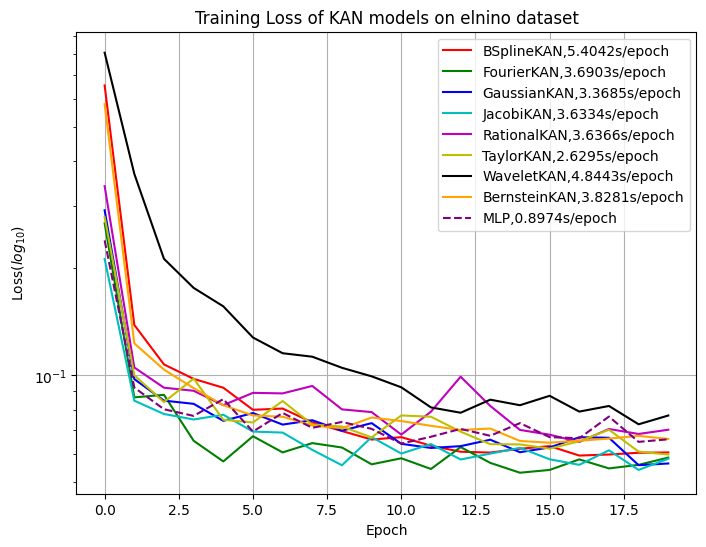

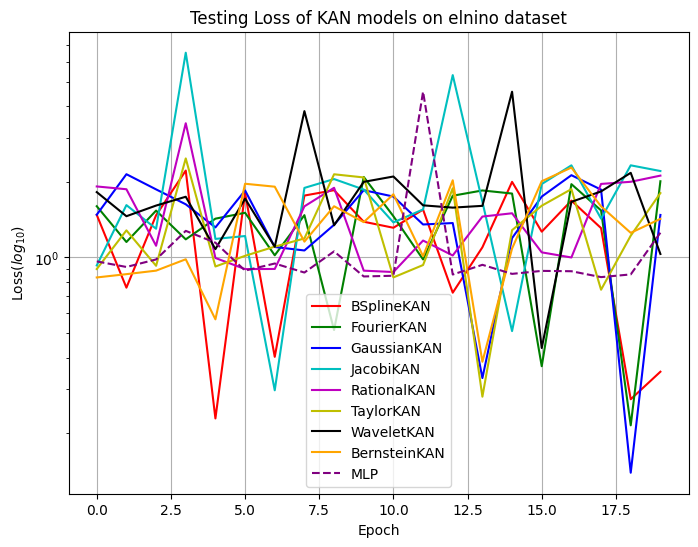

In [7]:
# Plot the loss curve
plt.figure(figsize=(8,6))
plt.plot(b_epoch_losses, label=f'BSplineKAN,{b_epoch_time:.4f}s/epoch', color='r')
plt.plot(f_epoch_losses, label=f'FourierKAN,{f_epoch_time:.4f}s/epoch', color='g')
plt.plot(g_epoch_losses, label=f'GaussianKAN,{g_epoch_time:.4f}s/epoch', color='b')
plt.plot(j_epoch_losses, label=f'JacobiKAN,{j_epoch_time:.4f}s/epoch', color='c')
plt.plot(r_epoch_losses, label=f'RationalKAN,{r_epoch_time:.4f}s/epoch', color='m')
plt.plot(t_epoch_losses, label=f'TaylorKAN,{t_epoch_time:.4f}s/epoch', color='y')
plt.plot(w_epoch_losses, label=f'WaveletKAN,{w_epoch_time:.4f}s/epoch', color='k')
plt.plot(be_epoch_losses, label=f'BernsteinKAN,{be_epoch_time:.4f}s/epoch', color='orange')
plt.plot(mlp_epoch_losses, label=f'MLP,{mlp_epoch_time:.4f}s/epoch', color='purple', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss($log_{10}$)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title('Training Loss of KAN models on elnino dataset')
plt.show()

# Plot the test loss curve
plt.figure(figsize=(8,6))
plt.plot(b_test_losses, label=f'BSplineKAN', color='r')
plt.plot(f_test_losses, label=f'FourierKAN', color='g')
plt.plot(g_test_losses, label=f'GaussianKAN', color='b')
plt.plot(j_test_losses, label=f'JacobiKAN', color='c')
plt.plot(r_test_losses, label=f'RationalKAN', color='m')
plt.plot(t_test_losses, label=f'TaylorKAN', color='y')
plt.plot(w_test_losses, label=f'WaveletKAN', color='k')
plt.plot(be_test_losses, label=f'BernsteinKAN', color='orange')
plt.plot(mlp_test_losses, label=f'MLP', color='purple', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss($log_{10}$)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title('Testing Loss of KAN models on elnino dataset')
plt.show()